# DNN 성능 향상시키기
- 앞에서 추가한 LAG와 휴일포함 데이터를 기존의 DNN에 훈련하여 차이를 확인

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import os
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## LAG 데이터만 포함

In [2]:
df = pd.read_csv('../data/훈련데이터셋/2_훈련데이터셋_LAG포함.csv')
df = df.drop(columns='날짜')

# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,지역코드,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워,lag_1d,lag_7d
0,1111010100,-1.5,6.5,3.5,9.6,52.5,147993.0770,141284.2660,146294.6135
1,1111010100,-2.0,6.2,5.3,9.6,73.4,161767.3595,147993.0770,175633.8270
2,1111010100,-6.4,6.1,4.5,9.6,70.8,170183.9965,161767.3595,156084.1910
3,1111010100,-8.5,5.4,3.6,9.6,79.1,184245.9485,184582.8110,177018.8420
4,1111010100,-9.6,5.0,2.1,9.6,56.9,176717.5230,184245.9485,158467.1690


### 데이터셋 나누기

In [3]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((152212, 8), (152212,))

In [4]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 8), (30443, 8), (121769,), (30443,))

### 훈련데이터 전처리
- 지역코드는 원핫인코딩 처리
- 나머지는 정규화 처리

In [5]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if col!='지역코드'])]
    )

In [6]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed.shape

(121769, 473)

In [ ]:
# 전처리 모델 저장하기
import joblib
import os
path = 'SimpleDNN_LAG포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(preprocessor, path+'preprocessor_LAG.joblib')

['SimpleDNN_LAG포함/preprocessor_LAG.joblib']

### 모델생성

In [8]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               242688    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2

In [9]:
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 11s 3ms/step - loss: 19109871616.0000 - mae: 31441.4629 - mse: 19109871616.0000 - val_loss: 12718605312.0000 - val_mae: 21119.3711 - val_mse: 12718605312.0000
Epoch 2/100
3045/3045 [==============================] - 10s 3ms/step - loss: 14151720960.0000 - mae: 22522.1211 - mse: 14151720960.0000 - val_loss: 11950131200.0000 - val_mae: 19570.2383 - val_mse: 11950131200.0000
Epoch 3/100
3045/3045 [==============================] - 10s 3ms/step - loss: 14272141312.0000 - mae: 22739.2051 - mse: 14272141312.0000 - val_loss: 12190094336.0000 - val_mae: 17770.4238 - val_mse: 12190094336.0000
Epoch 4/100
3045/3045 [==============================] - 10s 3ms/step - loss: 14073533440.0000 - mae: 22947.4043 - mse: 14073533440.0000 - val_loss: 11939145728.0000 - val_mae: 22631.7578 - val_mse: 11939145728.0000
Epoch 5/100
3045/3045 [==============================] - 10s 3ms/step - loss: 13330163712.0000 - mae: 22340.5215 - mse: 13330163712.0000

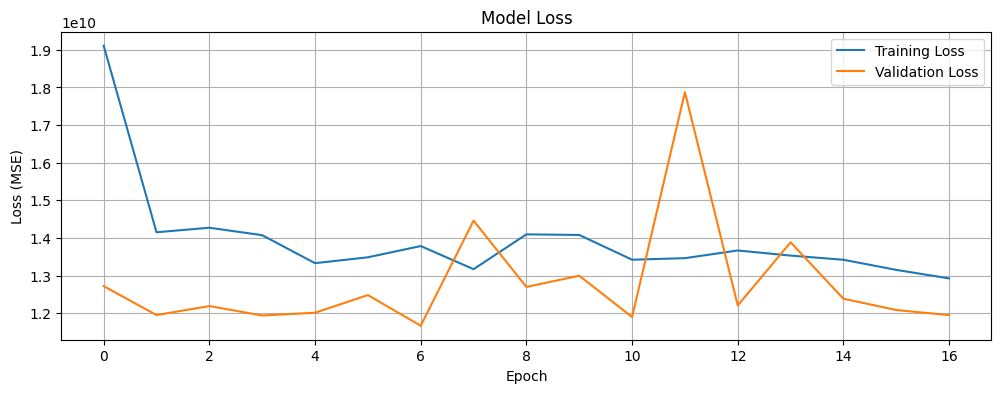

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [10]:
def evaluate_model(model, preprocessor, X_test, y_test, model_name):
    X_test_prep = preprocessor.transform(X_test)

    test_loss, test_mae, test_mse = model.evaluate(
        X_test_prep.toarray(),
        y_test,
        verbose=0
    )

    rmse = np.sqrt(test_mse)

    print(f"\n[Test Results - {model_name}]")
    print(f"  MSE : {test_mse:.4f}")
    print(f"  MAE : {test_mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    return {
        "model": model_name,
        "mse": float(test_mse),
        "mae": float(test_mae),
        "rmse": float(rmse),
        "n_test": len(y_test)
    }

import json
from datetime import datetime

def save_result_json(result: dict, filename: str):
    result = dict(result)  # 안전 복사
    result["saved_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    preprocessor=preprocessor,
    X_test=X_test,
    y_test=y_test,
    model_name="SimpleDNN (LAG 포함)"
)


[Test Results - DNN (LAG 포함)]
  MSE : 8253324288.0000
  MAE : 18137.0547
  RMSE: 90847.8084


In [ ]:
# 가장 마지막에 저장된 모델 (MSE가 가장 낮은 모델) 테스트
# 마지막 저장된 모델 외에는 삭제를 할 예정이기에 실행시 에러가 나는게 정상입니다
model1 = load_model(path+'DNN007_loss_11667294208.0000.h5')
res1 = evaluate_model(
    model=model1,
    preprocessor=preprocessor,
    X_test=X_test,
    y_test=y_test,
    model_name="SimpleDNN (LAG 포함)"
)


[Test Results - DNN (LAG 포함)]
  MSE : 8253324288.0000
  MAE : 18137.0547
  RMSE: 90847.8084


In [15]:
# 마지막 모델과 MSE가 가장 낮은 모델을 비교하여 더 괜찮은 모델을 최종모델로 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")

## LAG+휴일여부

In [16]:
df = pd.read_csv('../data/훈련데이터셋/3_훈련데이터셋_LAG_휴일포함.csv')
df = df.drop(columns='날짜')
df['휴일여부'] = df['휴일여부'].astype(int)
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,지역코드,최저기온(°C),0.5m 지중온도(°C),평균 증기압(hPa),가조시간(hr),평균 상대습도(%),파워,lag_1d,lag_7d,휴일여부
0,1111010100,-1.5,6.5,3.5,9.6,52.5,147993.0770,141284.2660,146294.6135,1
1,1111010100,-2.0,6.2,5.3,9.6,73.4,161767.3595,147993.0770,175633.8270,0
2,1111010100,-6.4,6.1,4.5,9.6,70.8,170183.9965,161767.3595,156084.1910,0
3,1111010100,-8.5,5.4,3.6,9.6,79.1,184245.9485,184582.8110,177018.8420,0
4,1111010100,-9.6,5.0,2.1,9.6,56.9,176717.5230,184245.9485,158467.1690,0


### 데이터셋 나누기

In [17]:
X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

((152212, 9), (152212,))

In [18]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 9), (30443, 9), (121769,), (30443,))

### 훈련데이터 전처리

In [19]:
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(), ['지역코드']), 
                ('standardScaler', StandardScaler(), [col for col in X.columns if (col!='지역코드') & (col!='휴일여부')])],
    remainder='passthrough'
    )

In [20]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1010254 stored elements and shape (121769, 474)>

In [21]:
# 전처리 모델 저장하기
import joblib
import os
path = 'SimpleDNN_LAG_휴일포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(preprocessor, path+'preprocessor_LAG.joblib')

['SimpleDNN_LAG_휴일포함/preprocessor_LAG.joblib']

### 모델생성

In [24]:
model = Sequential()
model.add(Input(X_train_preprocessed.shape[1],))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='relu'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               243200    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)               

In [25]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit(X_train_preprocessed.toarray(), y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 11s 3ms/step - loss: 17638955008.0000 - mae: 29239.6445 - mse: 17638955008.0000 - val_loss: 11729234944.0000 - val_mae: 16284.3877 - val_mse: 11729234944.0000
Epoch 2/100
3045/3045 [==============================] - 10s 3ms/step - loss: 12511722496.0000 - mae: 21381.1172 - mse: 12511722496.0000 - val_loss: 11832606720.0000 - val_mae: 18293.5098 - val_mse: 11832606720.0000
Epoch 3/100
3045/3045 [==============================] - 10s 3ms/step - loss: 12668205056.0000 - mae: 20556.0371 - mse: 12668205056.0000 - val_loss: 12401709056.0000 - val_mae: 17378.6797 - val_mse: 12401709056.0000
Epoch 4/100
3045/3045 [==============================] - 10s 3ms/step - loss: 12607218688.0000 - mae: 19740.6758 - mse: 12607218688.0000 - val_loss: 10912525312.0000 - val_mae: 15672.0488 - val_mse: 10912525312.0000
Epoch 5/100
3045/3045 [==============================] - 10s 3ms/step - loss: 12455848960.0000 - mae: 19761.9395 - mse: 12455848960.0000

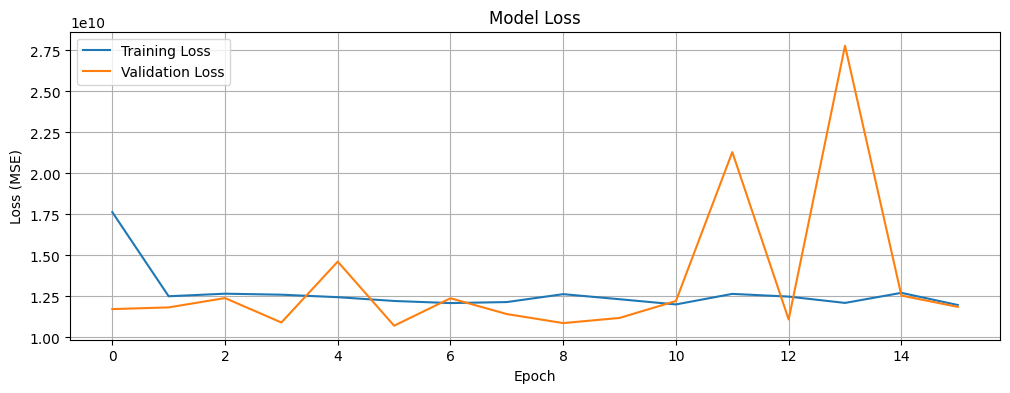

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    preprocessor=preprocessor,
    X_test=X_test,
    y_test=y_test,
    model_name="SimpleDNN (LAG_휴일 포함)"
)


[Test Results - DNN (LAG_휴일 포함)]
  MSE : 10537024512.0000
  MAE : 14394.4590
  RMSE: 102650.0098


In [30]:
#모델 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")

## Embedding Layer 사용하기

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Embedding, Flatten
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### LAG/휴일유무 없이

In [32]:
# 데이터 가져오기
df = pd.read_csv('../data/훈련데이터셋/1_훈련데이터셋_날짜미포함.csv')

X = df.drop(columns='파워')
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((145126, 6), (36282, 6), (145126,), (36282,))

In [ ]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])


num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if col != '지역코드']
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])

print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
import os
path = 'EmbeddingDNN_날짜미포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(label_encoder, path+'labelEncoder.joblib')
joblib.dump(scaler, path+'standardScaler.joblib')


법정동 수: 466
나머지 데이터 수: (145126, 5)


['EmbeddingDNN_날짜미포함/standardScaler.joblib']

In [35]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten (Flatten)              (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 5)]          0           []                               
                                                                                              

In [36]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3629/3629 [==============================] - 11s 3ms/step - loss: 52920451072.0000 - mae: 50492.3516 - mse: 52920451072.0000 - val_loss: 33417009152.0000 - val_mae: 38792.0039 - val_mse: 33417009152.0000
Epoch 2/100
3629/3629 [==============================] - 10s 3ms/step - loss: 45644103680.0000 - mae: 39960.0352 - mse: 45644103680.0000 - val_loss: 30161500160.0000 - val_mae: 34178.6406 - val_mse: 30161500160.0000
Epoch 3/100
3629/3629 [==============================] - 10s 3ms/step - loss: 44213149696.0000 - mae: 37171.2383 - mse: 44213149696.0000 - val_loss: 29814996992.0000 - val_mae: 30415.4512 - val_mse: 29814996992.0000
Epoch 4/100
3629/3629 [==============================] - 10s 3ms/step - loss: 43348746240.0000 - mae: 35962.6211 - mse: 43348746240.0000 - val_loss: 27981139968.0000 - val_mae: 30362.3574 - val_mse: 27981139968.0000
Epoch 5/100
3629/3629 [==============================] - 10s 3ms/step - loss: 42943033344.0000 - mae: 34788.7891 - mse: 42943033344.0000

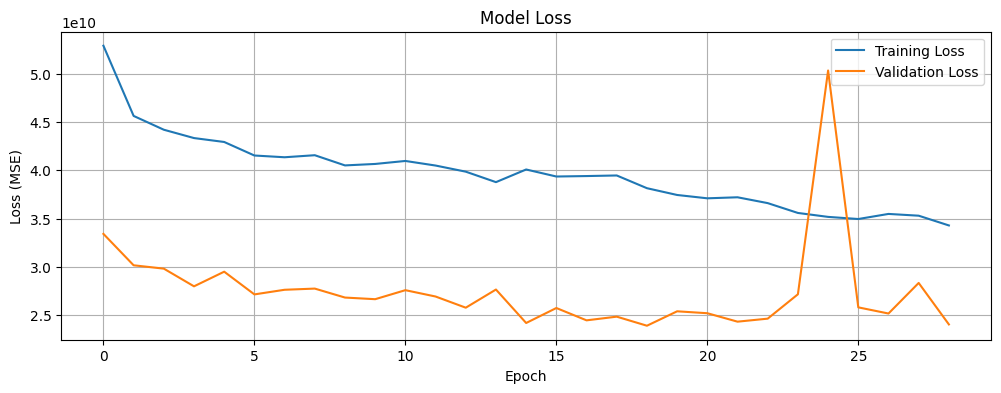

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [39]:
def evaluate_model(model, label_encoder, scaler, X_test, y_test, model_name):
    X_test_numeric = scaler.transform(X_test[numeric_cols])
    X_test_region = label_encoder.transform(X_test['지역코드'])

    test_loss, test_mae, test_mse = model.evaluate(
        [X_test_region,X_test_numeric],
        y_test,
        verbose=0
    )

    rmse = np.sqrt(test_mse)

    print(f"\n[Test Results - {model_name}]")
    print(f"  MSE : {test_mse:.4f}")
    print(f"  MAE : {test_mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    return {
        "model": model_name,
        "mse": float(test_mse),
        "mae": float(test_mae),
        "rmse": float(rmse),
        "n_test": len(y_test)
    }

import json
from datetime import datetime

def save_result_json(result: dict, filename: str):
    result = dict(result)  # 안전 복사
    result["saved_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    label_encoder=label_encoder,
    scaler=scaler,
    X_test=X_test,
    y_test=y_test,
    model_name="EmbeddingDNN (LAG_휴일 포함)"
)


[Test Results - DNN (LAG_휴일 포함)]
  MSE : 26053705728.0000
  MAE : 25462.4219
  RMSE: 161411.6034


In [42]:
#모델 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")

### LAG 포함

In [49]:
# 데이터 가져오기
df = pd.read_csv('../data/훈련데이터셋/2_훈련데이터셋_LAG포함.csv')
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)

X = df.drop(columns=['파워','날짜'])
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 8), (30443, 8), (121769,), (30443,))

In [50]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])

num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if col != '지역코드']
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_cols])

print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
import os
path = 'EmbeddingDNN_LAG포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(label_encoder, path+'labelEncoder.joblib')
joblib.dump(scaler, path+'standardScaler.joblib')


법정동 수: 466
나머지 데이터 수: (121769, 7)


['EmbeddingDNN_LAG포함/standardScaler.joblib']

In [51]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten_2 (Flatten)            (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 7)]          0           []                               
                                                                                            

In [52]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 9s 3ms/step - loss: 18371461120.0000 - mae: 30447.5938 - mse: 18371461120.0000 - val_loss: 19433211904.0000 - val_mae: 30573.0020 - val_mse: 19433211904.0000
Epoch 2/100
3045/3045 [==============================] - 9s 3ms/step - loss: 13441515520.0000 - mae: 22671.7051 - mse: 13441515520.0000 - val_loss: 13103202304.0000 - val_mae: 20802.8359 - val_mse: 13103202304.0000
Epoch 3/100
3045/3045 [==============================] - 9s 3ms/step - loss: 12817989632.0000 - mae: 22068.3359 - mse: 12817989632.0000 - val_loss: 13094747136.0000 - val_mae: 18746.6582 - val_mse: 13094747136.0000
Epoch 4/100
3045/3045 [==============================] - 9s 3ms/step - loss: 12991048704.0000 - mae: 20740.6641 - mse: 12991048704.0000 - val_loss: 12434481152.0000 - val_mae: 16670.7168 - val_mse: 12434481152.0000
Epoch 5/100
3045/3045 [==============================] - 8s 3ms/step - loss: 13221249024.0000 - mae: 22092.6191 - mse: 13221249024.0000 - va

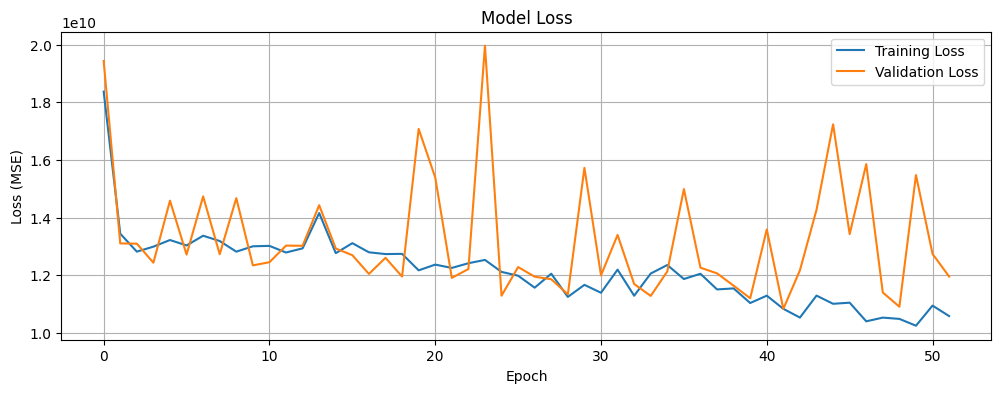

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    label_encoder=label_encoder,
    scaler=scaler,
    X_test=X_test,
    y_test=y_test,
    model_name="EmbeddingDNN (LAG_휴일 포함)"
)


[Test Results - DNN (LAG_휴일 포함)]
  MSE : 8835653632.0000
  MAE : 15777.3076
  RMSE: 93998.1576


In [55]:
#모델 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")

### LAG+휴일 포함

In [65]:
df = pd.read_csv('../data/훈련데이터셋/3_훈련데이터셋_LAG_휴일포함.csv')
df['휴일여부'] = df['휴일여부'].astype(int)
# 결측치 있는 값들은 제거
df = df.dropna(axis=0).reset_index(drop=True)

X = df.drop(columns=['파워','날짜'])
y = df['파워']
X.shape, y.shape

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((121769, 9), (30443, 9), (121769,), (30443,))

In [66]:
# 훈련데이터 전처리
# 법정동 레이블 인코딩
label_encoder = LabelEncoder()
X_train_region = label_encoder.fit_transform(X_train['지역코드'])


num_regions = len(label_encoder.classes_)
print(f"법정동 수: {num_regions}")

# binary 데이터
binary_cols = ['휴일여부']
X_train_binary = X_train[binary_cols].values


# 나머지 데이터 표준화
numeric_cols = [col for col in X_train.columns if (col != '지역코드') & (col not in binary_cols)]
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_cols])

# 숫자 데이터 합치기
X_train_numeric = np.concatenate([X_train_numeric_scaled, X_train_binary], axis=1)


print(f"나머지 데이터 수: {X_train_numeric.shape}")

# 전처리 모델 저장하기
import joblib
import os
path = 'EmbeddingDNN_LAG_휴일포함/'
if not os.path.exists(path):
    os.mkdir(path)
joblib.dump(label_encoder, path+'labelEncoder.joblib')
joblib.dump(scaler, path+'standardScaler.joblib')



법정동 수: 466
나머지 데이터 수: (121769, 8)


['EmbeddingDNN_LAG_휴일포함/standardScaler.joblib']

In [67]:
# 모델 생성
region_input = Input(shape=(1,), name='region_input')
numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')

region_embedding = Embedding(
    input_dim=num_regions,
    output_dim=50,
    name='region_embedding'
)(region_input)

region_embedding = Flatten()(region_embedding)
concatenated = Concatenate()([region_embedding, numeric_input])


x = Dense(512, activation='relu')(concatenated)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='relu')(x)

model = Model(inputs=[region_input, numeric_input], outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 region_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 region_embedding (Embedding)   (None, 1, 50)        23300       ['region_input[0][0]']           
                                                                                                  
 flatten_5 (Flatten)            (None, 50)           0           ['region_embedding[0][0]']       
                                                                                                  
 numeric_input (InputLayer)     [(None, 8)]          0           []                               
                                                                                            

In [68]:
import os
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

filename = 'DNN{epoch:03d}_loss_{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=path+filename, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

hist = model.fit([X_train_region, X_train_numeric], y_train, callbacks=[earlyStop, checkpoint], validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
3045/3045 [==============================] - 9s 3ms/step - loss: 20844183552.0000 - mae: 32129.5117 - mse: 20844183552.0000 - val_loss: 10362695680.0000 - val_mae: 20518.8203 - val_mse: 10362695680.0000
Epoch 2/100
3045/3045 [==============================] - 8s 3ms/step - loss: 14282362880.0000 - mae: 23280.6348 - mse: 14282362880.0000 - val_loss: 9225232384.0000 - val_mae: 21479.6934 - val_mse: 9225232384.0000
Epoch 3/100
3045/3045 [==============================] - 8s 3ms/step - loss: 13888490496.0000 - mae: 21760.1445 - mse: 13888490496.0000 - val_loss: 8485096448.0000 - val_mae: 15704.7588 - val_mse: 8485096448.0000
Epoch 4/100
3045/3045 [==============================] - 8s 3ms/step - loss: 13692804096.0000 - mae: 20797.7441 - mse: 13692804096.0000 - val_loss: 10915253248.0000 - val_mae: 19252.8965 - val_mse: 10915253248.0000
Epoch 5/100
3045/3045 [==============================] - 8s 3ms/step - loss: 14077979648.0000 - mae: 21054.7988 - mse: 14077979648.0000 - val_lo

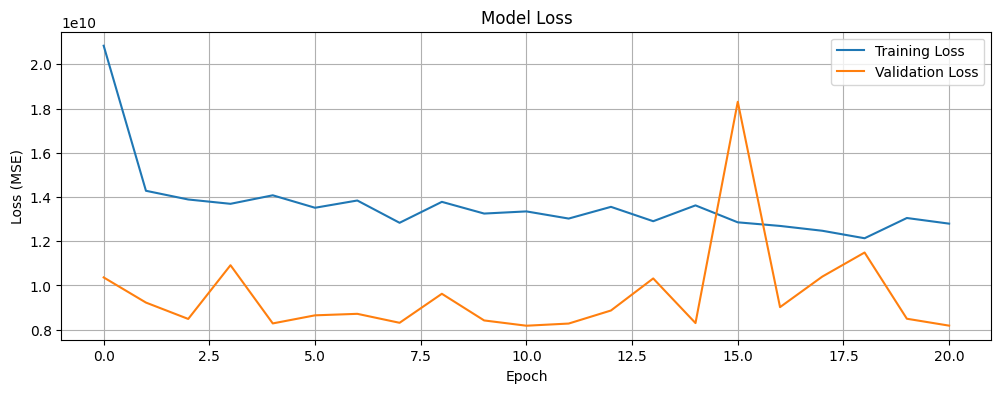

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

In [72]:
def evaluate_model(model, label_encoder, scaler, X_test, y_test, model_name):
    X_test_numeric_scaled = scaler.transform(X_test[numeric_cols])
    X_test_binary = X_test[binary_cols].values
    X_test_region = label_encoder.transform(X_test['지역코드'])
    X_test_numeric = np.concatenate([X_test_numeric_scaled, X_test_binary], axis=1)

    test_loss, test_mae, test_mse = model.evaluate(
        [X_test_region,X_test_numeric],
        y_test,
        verbose=0
    )

    rmse = np.sqrt(test_mse)

    print(f"\n[Test Results - {model_name}]")
    print(f"  MSE : {test_mse:.4f}")
    print(f"  MAE : {test_mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    return {
        "model": model_name,
        "mse": float(test_mse),
        "mae": float(test_mae),
        "rmse": float(rmse),
        "n_test": len(y_test)
    }

import json
from datetime import datetime

def save_result_json(result: dict, filename: str):
    result = dict(result)  # 안전 복사
    result["saved_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    with open(filename, "w", encoding="utf-8") as f:
        json.dump(result, f, ensure_ascii=False, indent=2)

In [ ]:
# 마지막 모델 테스트
res = evaluate_model(
    model=model,
    label_encoder=label_encoder,
    scaler=scaler,
    X_test=X_test,
    y_test=y_test,
    model_name="EmbeddingDNN (LAG_휴일 포함)"
)


[Test Results - DNN (LAG_휴일 포함)]
  MSE : 9311087616.0000
  MAE : 14028.2266
  RMSE: 96493.9771


In [74]:
#모델 저장
save_result_json(res, path+"result.json")
save_model(model, path+"final_model.h5")